In [1]:
import torch
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt

from burgers import BurgersDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
nx = 8192
batch_num = 27
filename = f"data/samples/N{nx}_nu0.01_samples40_batch{batch_num}"

with fd.CheckpointFile(f"data/meshes/N{nx}.h5", "r") as file:
    function_space = fd.FunctionSpace(file.load_mesh(), "CG", degree=1)


data = torch.load(f"{filename}.pt").unsqueeze(2).to(device=device, dtype=torch.float32)

index = 35
datapoint = data[index]
func_in = fd.Function(function_space, val=datapoint[0][0].detach().cpu())
func_out = fd.Function(function_space, val=datapoint[1][0].detach().cpu())

fig, axes = plt.subplots()

fd.plot(func_in, axes=axes, label="Input")
fd.plot(func_out, axes=axes, label="Output")
axes.legend()


Error: error code 76
[0] PetscViewerFileSetName() at /home/clustor2/ma/n/np923/firedrake/src/petsc/src/sys/classes/viewer/impls/ascii/filev.c:837
[0] PetscViewerFileSetName_HDF5() at /home/clustor2/ma/n/np923/firedrake/src/petsc/src/sys/classes/viewer/impls/hdf5/hdf5v.c:424
[0] Error in external library
[0] Error in HDF5 call H5Fopen() Status -1

In [3]:

nx = 8192
batch_num = 1
filename = f"data/samples/N{nx}_nu0.01_samples200_batch{batch_num}"

max_modes = 8
d = 10

# net = torch.load(f"models_L2/nx_{nx}__d_{d}__max_modes_{max_modes}.pt").to(device=device)
# param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
# print(f"Number of parameters: {param_num}")

data = torch.load(f"{filename}.pt").unsqueeze(2).to(device=device, dtype=torch.float32)
# grid = torch.linspace(0, 1, nx, device=device)
# testset = BurgersDataset(data[int(0.8 * len(data)):], grid)

# prediction_coeffs = net(testset[:][0]).detach().cpu()

with fd.CheckpointFile(f"data/meshes/N{nx}.h5", "r") as file:
    function_space = fd.FunctionSpace(file.load_mesh(), "CG", degree=1)




initial_functions = []
solutions = []
predictions = []
for predict, datapoint in zip(prediction_coeffs, testset):
    initial_functions.append(fd.Function(function_space, val=datapoint[0][0].detach().cpu()))
    solutions.append(fd.Function(function_space, val=datapoint[1][0].detach().cpu()))
    predictions.append(fd.Function(function_space, val=predict[0]))

# Number of points for plotting
num_plot_points = 1000
plot_points = np.linspace(0, 1, num_plot_points)

# Create a figure for plotting
fig, ax = plt.subplots()

# Plot each function
index = 25
for func, label in zip([solutions[index], predictions[index], initial_functions[index]], ["Firedrake solution", "Network solution", "Initial condition"]):
    # Evaluate the function at the plot points
    plot_values = np.array([func.at(x) for x in plot_points])

    # Plot the function
    ax.plot(plot_points, plot_values, label=label)

# Set plot labels and title
ax.set_xlabel("$x$")
ax.set_title(f"Burgers solutions - Firedrake and Network, $N_x={nx}, \, D={d}$")
ax.legend()

# Show the plot
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/samples/N8192_nu0.01_samples200_batch1.pt'

In [1]:
from firedrake import *

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
mesh = PeriodicIntervalMesh(100, 1)


In [17]:
her_fs = FunctionSpace(mesh, "HER", 3)
x = SpatialCoordinate(mesh)[0]
v = TestFunction(her_fs)
f = assemble(sin(2 * pi * x) * v * dx)
sum(f.dat.data)

np.float64(-1.9714183627575488e-16)

In [20]:
her_fs = FunctionSpace(mesh, "CG", 3)
x = SpatialCoordinate(mesh)[0]
v = TestFunction(her_fs)
f = assemble(sin(2 * pi * x) * v * dx)
sum(f.dat.data)

np.float64(4.517057301117733e-17)

In [3]:
def check_downsample(fs1, data1, fs2, data2, index=100):
    fig1, axes1 = plt.subplots()
    fig2, axes2 = plt.subplots()

    fd.plot(fd.Function(fs1, val=data1[index, 0, :], name="FS1 - a"), axes=axes1)
    fd.plot(fd.Function(fs2, val=data2[index, 0, :], name="FS2 - a"), axes=axes1)
    fd.plot(fd.Function(fs1, val=data1[index, 1, :], name="FS1 - u"), axes=axes2)
    fd.plot(fd.Function(fs2, val=data2[index, 1, :], name="FS2 - u"), axes=axes2)

    axes1.legend()
    axes1.grid()
    axes2.legend()
    axes2.grid()

    plt.show()

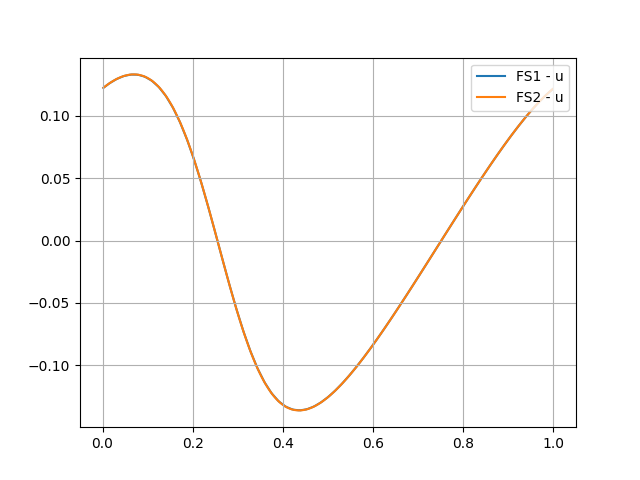

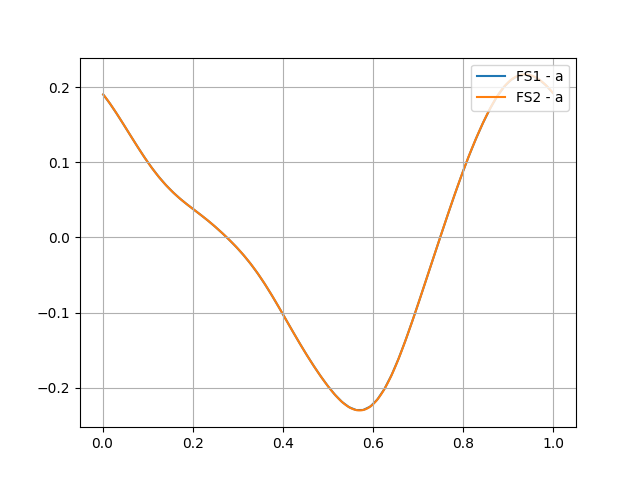

In [22]:
%matplotlib widget
N1 = 64
N2 = 1024

data1 = torch.load(f"data/burgers/samples/N{N1}_nu001_T1_samples1200.pt").numpy()
data2 = torch.load(f"data/burgers/samples/N{N2}_nu001_T1_samples1200.pt").numpy()

with fd.CheckpointFile(f"data/burgers/meshes/N{N1}.h5", "r") as file:
    fs1 = fd.FunctionSpace(file.load_mesh(), "CG", 1)

with fd.CheckpointFile(f"data/burgers/meshes/N{N2}.h5", "r") as file:
    fs2 = fd.FunctionSpace(file.load_mesh(), "CG", 1)

check_downsample(fs1, data1, fs2, data2)


In [125]:
from firedrake import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from classes import *
from classes.Dataset import Dataset
device = torch.device("cuda:3") if torch.cuda.is_available() else torch.device("cpu")


In [130]:
N_domain = [64, 128, 256, 512, 1024, 2048, 4096, 8192]
N_losses = []
for i, N in enumerate(N_domain):
    model = BurgersModel.load(f"data/burgers/models/fourier/N{N}/T1/D20_M8_samples1000_epoch500.pt", N, "01", device)
    data_path = f"data/burgers/samples/N{N}_nu001_T1_samples1200.pt"
    
    samples = torch.load(data_path).unsqueeze(2).to(device=device, dtype=torch.float32)
    grid = torch.linspace(0, model.L, model.dof_count, device=device)
    trainset = Dataset(torch.tensor(samples[:model.train_samples]), torch.tensor(grid))
    testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))
    
    mse_loss = nn.MSELoss(reduction="sum")
    loss = lambda x, y: mse_loss(x, y) / N  # Sum of differences, times step size, divide by batch size
    optimizer = torch.optim.Adam(model.network.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.5)
    
    network_trainer = NeuralNetworkTrainer(
        model,
        trainset,
        testset,
        loss,
        optimizer,
        scheduler,
        max_epoch=500
    )
    
    N_losses.append(network_trainer.test_epoch().detach().cpu().numpy())
        

/tmp/ipykernel_3986385/3345744576.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainset = Dataset(torch.tensor(samples[:model.train_samples]), torch.tensor(grid))
/tmp/ipykernel_3986385/3345744576.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))


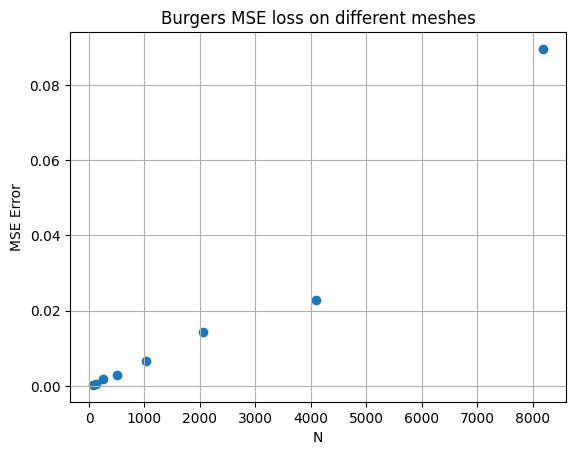

In [131]:
fig, axes = plt.subplots()
axes.scatter(N_domain, N_losses)
    
axes.set_xlabel("N")
axes.set_ylabel("MSE Error")
axes.set_title("Burgers MSE loss on different meshes")

axes.grid()


In [11]:
N = 8192
D_domain = [i * 10 for i in range(1, 7)]
M_domain = [1, 4, 8]
M_losses = {1: [], 4: [], 8: []}
for M in M_domain:
    for i, D in enumerate(D_domain):
        model = BurgersModel.load(f"data/burgers/models/fourier/N{N}/T1/D{D}_M{M}_samples1000_epoch500.pt", N, "01", device)
        data_path = f"data/burgers/samples/N{N}_nu001_T1_samples1200.pt"
        
        samples = torch.load(data_path).unsqueeze(2).to(device=device, dtype=torch.float32)
        grid = torch.linspace(0, model.L, model.dof_count, device=device)
        trainset = Dataset(torch.tensor(samples[:model.train_samples]), torch.tensor(grid))
        testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))
        
        mse_loss = nn.MSELoss(reduction="sum")
        loss = lambda x, y: mse_loss(x, y) /N  # Sum of differences, times step size, divide by batch size
        
        optimizer = torch.optim.Adam(model.network.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.5)
        
        network_trainer = NeuralNetworkTrainer(
            model,
            trainset,
            testset,
            loss,
            optimizer,
            scheduler,
            max_epoch=500
        )
        
        M_losses[M].append(network_trainer.test_epoch().detach().cpu().numpy())
            

/tmp/ipykernel_3644789/3683626661.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainset = Dataset(torch.tensor(samples[:model.train_samples]), torch.tensor(grid))
/tmp/ipykernel_3644789/3683626661.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testset = Dataset(torch.tensor(samples[model.train_samples:]), torch.tensor(grid))


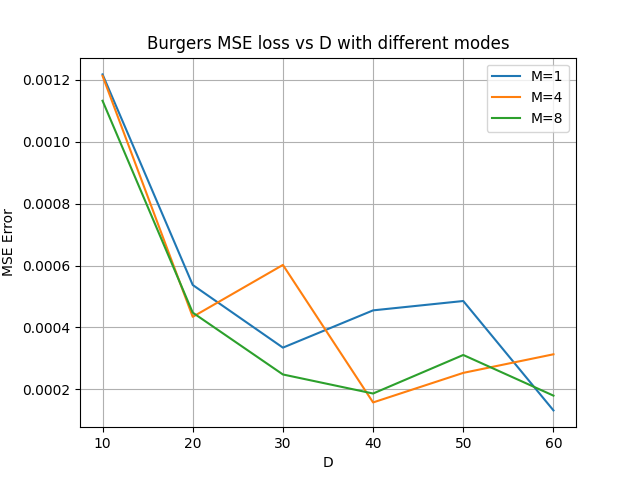

In [12]:
fig, axes = plt.subplots()

for M in M_losses.keys():
    axes.plot(D_domain, M_losses[M], label=f"M={M}")
    
axes.set_xlabel("D")
axes.set_ylabel("MSE Error")
axes.set_title("Burgers MSE loss vs D with different modes")
axes.legend()

axes.grid()

# Loss norm check across meshes

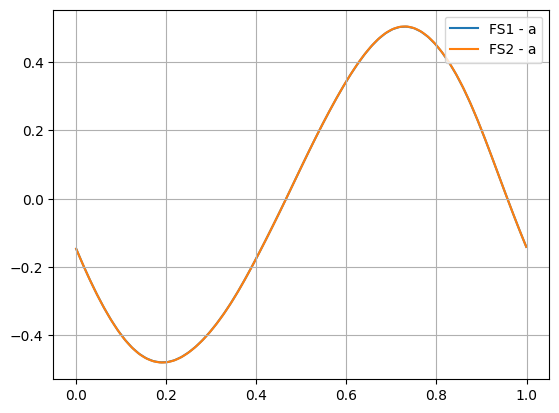

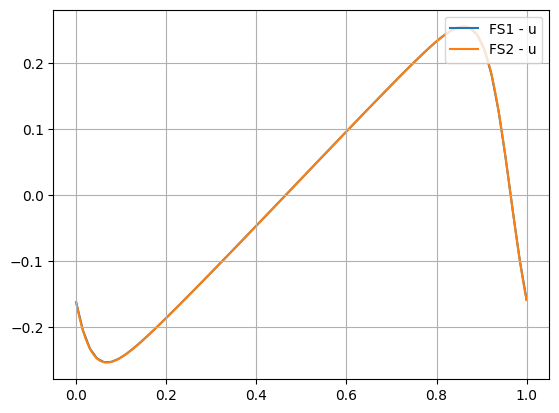

In [4]:
index = 50
N1 = 64
N2 = 1024

data1 = torch.load(f"data/burgers/samples/N{N1}_nu001_T1_samples1200.pt")
data2 = torch.load(f"data/burgers/samples/N{N2}_nu001_T1_samples1200.pt")

with fd.CheckpointFile(f"data/burgers/meshes/N{N1}.h5", "r") as file:
    mesh1 = file.load_mesh()
    fs1 = fd.FunctionSpace(mesh1, "CG", 1)

with fd.CheckpointFile(f"data/burgers/meshes/N{N2}.h5", "r") as file:
    mesh2 = file.load_mesh()
    fs2 = fd.FunctionSpace(mesh2, "CG", 1)
    

check_downsample(fs1, data1.numpy(), fs2, data2.numpy(), index=index)

In [12]:
func_in_N1 = fd.Function(fs1, val=data1[index, 0, :])
func_out_N1 = fd.Function(fs1, val=data1[index, 1, :])

func_in_N2 = fd.Function(fs2, val=data2[index, 0, :])
func_out_N2 = fd.Function(fs2, val=data2[index, 1, :])

print(f"Errornorm N{N1}: {fd.errornorm(func_in_N1, func_out_N1)}")
print(f"Errornorm N{N2}: {fd.errornorm(func_in_N2, func_out_N2)}")


Errornorm N64: 0.20400927089329335
Errornorm N1024: 0.20425529433106604


In [23]:
mse_loss = torch.nn.MSELoss(reduction="sum")
loss_N1 = lambda x, y: torch.sqrt(mse_loss(x, y) / N1)
loss_N2 = lambda x, y: torch.sqrt(mse_loss(x, y) / N2)

In [6]:
coeff_in_N1 = data1[index, 0, :]
coeff_out_N1 = data1[index, 1, :]

coeff_in_N2 = data2[index, 0, :]
coeff_out_N2 = data2[index, 1, :]

In [25]:
print(f"Coefficient errornorm N{N1}: {loss_N1(coeff_in_N1, coeff_out_N1)}")
print(f"Coefficient errornorm N{N2}: {loss_N2(coeff_in_N2, coeff_out_N2)}")

Coefficient errornorm N64: 0.2042563110589981
Coefficient errornorm N1024: 0.20425626635551453


In [47]:
64 * (mesh1.coordinates.dat.data[4] - mesh1.coordinates.dat.data[5])

np.float64(-0.9999999999999996)

In [7]:
torch.sqrt(torch.sum(torch.square(coeff_in_N1 - coeff_out_N1))/N1)

tensor(0.2043)

In [116]:
N_domain = [64, 128, 256, 512, 1024, 2048, 4096, 8192]
N_losses = np.array([])
for i, N in enumerate(N_domain):
    data_path = f"data/burgers/samples/N{N}_nu001_T1_samples1200.pt"    
    samples = torch.load(data_path).to(device=device, dtype=torch.float64)[1000:]
    
    mse_loss = nn.MSELoss(reduction="sum")
    loss = lambda x, y: mse_loss(x, y) / (N * len(x))

    N_losses = np.append(N_losses, loss(samples[:, 0], samples[:, 1]).cpu().numpy())

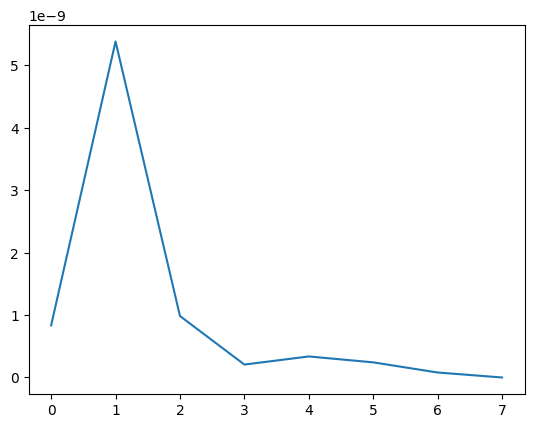

In [123]:
plt.plot(np.abs((N_losses- N_losses[-1])/N_losses[-1]))

In [37]:
torch.sum(torch.square(data1[0, 0, :] - data1[0, 1, :]))/N1

tensor(0.0017)

In [38]:
torch.sum(torch.square(data2[0, 0, :] - data2[0, 1, :]))/N2

tensor(0.0017)

In [66]:
model1 = BurgersModel.load(f"data/burgers/models/fourier/N{N1}/T1/D{20}_M{8}_samples1000_epoch500.pt", N1, "01", device)
model2 = BurgersModel.load(f"data/burgers/models/fourier/N{N2}/T1/D{20}_M{8}_samples1000_epoch500.pt", N1, "01", device)


In [43]:

test_network = NeuralOperatorNetwork(8, 10, 3, model1.projection)

In [56]:
modules = []
for m in test_network.modules():
    modules.append(m)


torch.Size([10, 10, 1])

In [57]:
modules[3][0].linear.weight.shape

torch.Size([10, 10, 1])

In [58]:
modules[3][0].linear.bias

Parameter containing:
tensor([-0.0039, -0.2471, -0.1370,  0.0751, -0.0233, -0.1280, -0.2508, -0.1274,
        -0.1436, -0.1730], requires_grad=True)

In [59]:
model1.named_modules()

AttributeError: 'BurgersModel' object has no attribute 'named_modules'

In [61]:
model1_modules = [m for m in model1.network.modules()]

In [65]:
model1_modules[3][0].weights.shape

torch.Size([17, 20, 20])

In [103]:
torch.sum(model1.projection.coeff[1])

tensor(4.2013e-18, device='cuda:3')

In [105]:
torch.sum(model2.projection.coeff[1]

tensor([-7.4359e-19,  1.1984e-05,  2.3968e-05,  ..., -3.5951e-05,
        -2.3968e-05, -1.1984e-05], device='cuda:3')

In [113]:
model1.projection.coeff.shape

torch.Size([17, 64])

In [114]:
test_network = NeuralOperatorNetwork(8, 10, 3, model1.projection)
modules[3]

NeuralOperatorLayer(
  (linear): Conv1d(10, 10, kernel_size=(1,), stride=(1,))
)

In [188]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import firedrake as fd

class NeuralOperatorLayerTest(nn.Module):
    def __init__(
            self,
            N: int,
            M: int,
            D: int,
            projection,
            device: str
    ):
        """
        A network module that performs the interior layers operation in the Nonlocal Neural Operator architecture.
        This includes: Linear transformation with bias, preprojection linear transformation, projection to 'psi'
        functions (multiplication by coefficient), and nonlinearity.

        Args:
            M (int): Number of Fourier modes.
            D (int): Number of channels for fan-out.
            projection (ProjectionCoefficient): An instance of ProjectionCoefficient.
            device (str): Torch device to use ('cpu' or 'cuda').
        """
        super().__init__()

        self.coeff = projection.coeff
        self.coeff_T = projection.coeff.T

        # Linear matrix multiplication that mixes up the channels (W operator), also called MLP. It includes the bias.
        self.linear = nn.Conv1d(D, D, kernel_size=1, device=device)
        with torch.no_grad():
            self.linear.weight.data /= N
            self.linear.bias.data /= N
        
        self.weights = nn.Parameter(torch.rand(2 * M + 1, D, D, requires_grad=True, device=device))  # MxDxD parameters

    def forward(self, u):
        wu = self.linear(u)
        s = torch.einsum("mji, bim, mn -> bjn", self.weights, u @ self.coeff_T, self.coeff)
        
        return functional.gelu(wu + s) # Changed this to use s only!


In [192]:
from collections import defaultdict

# sums = defaultdict(list)

index = 10
N_domain = [64, 128, 256, 512, 1024, 2048, 4096, 8192]

for i, N in enumerate(N_domain):
    model = BurgersModel.load(f"data/burgers/models/fourier/N{N}/T1/D20_M8_samples1000_epoch500.pt", N, "01", device)
    data_path = f"data/burgers/samples/N{N}_nu001_T1_samples1200.pt"
    
    samples = torch.load(data_path).unsqueeze(2).to(device=device, dtype=torch.float32)

    for _ in range(2000):
        network = NeuralOperatorLayerTest(N, 8, 10, model.projection, device)
        sample = samples[index, 0, :].repeat(10, 1).unsqueeze(0)

        sums[N].append(torch.sum(network(sample)))

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU  has a total capacity of 23.68 GiB of which 5.00 MiB is free. Process 3859423 has 6.50 GiB memory in use. Process 3859718 has 6.50 GiB memory in use. Process 3944002 has 6.55 GiB memory in use. Including non-PyTorch memory, this process has 4.11 GiB memory in use. Of the allocated memory 3.68 GiB is allocated by PyTorch, and 128.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [193]:
for N in N_domain:
    print(f"N={N}, mean={np.mean([num.detach().cpu().numpy() for num in sums[N]])}")

N=64, mean=0.4716300070285797
N=128, mean=0.236656054854393
N=256, mean=0.12185897678136826
N=512, mean=0.05144990235567093
N=1024, mean=0.01612243242561817
N=2048, mean=0.011854448355734348
N=4096, mean=0.005207524169236422
N=8192, mean=0.012698839418590069
